# Class attention applied to a text classification task using BERT

Take ~two~ three. Hopefully, the preprocessing tools will help to avoid bugs.

Read more about the preprocessing in the previous notebook `06_fcn_for_real_data.ipynb`.

In [ ]:
import copy
import random
from pprint import pprint
from itertools import chain

import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers
from transformers import AutoModel, AutoTokenizer
import datasets

import wandb
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import class_attention as cat

%load_ext autoreload
%autoreload 2


def detorch(x):
    return x.detach().cpu().numpy()

# Data

In [ ]:
def sample_dataset(dataset, p):
    """
    Args:
        dataset: datasets.arrow_dataset.Dataset object
        p: float, 0 < p <= 1
    
    Returns:
        datasets.arrow_dataset.Dataset of size len(dataset) * p with random examples from the dataset
        sampled without replacement
    """
    if not 0 < p <= 1:
        raise ValueError(p)

    dataset_len = len(dataset)
    sample_size = int(p * dataset_len)

    ids = random.sample(range(len(dataset)), sample_size)
    
    # indexing actually creates dict with elements of len(ids), not a list
    sampled_dataset_dict = dataset[ids]
    sampled_dataset = datasets.arrow_dataset.Dataset.from_dict(sampled_dataset_dict)
    return sampled_dataset

In [3]:
text_dataset = datasets.load_dataset("Fraser/news-category-dataset")
all_classes = text_dataset['train'].features['category_num'].names
print(all_classes)

toy_dataset = sample_dataset(text_dataset['train'], 0.01)
len(toy_dataset)

Using custom data configuration default
Reusing dataset news_category (/home/vlialin/.cache/huggingface/datasets/news_category/default/0.0.0/737b7b6dff469cbba49a6202c9e94f9d39da1fed94e13170cf7ac4b61a75fb9c)


['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'STYLE & BEAUTY', 'PARENTING', 'HEALTHY LIVING', 'QUEER VOICES', 'FOOD & DRINK', 'BUSINESS', 'COMEDY', 'SPORTS', 'BLACK VOICES', 'HOME & LIVING', 'PARENTS', 'THE WORLDPOST', 'WEDDINGS', 'WOMEN', 'IMPACT', 'DIVORCE', 'CRIME', 'MEDIA', 'WEIRD NEWS', 'GREEN', 'WORLDPOST', 'RELIGION', 'STYLE', 'SCIENCE', 'WORLD NEWS', 'TASTE', 'TECH', 'MONEY', 'ARTS', 'FIFTY', 'GOOD NEWS', 'ARTS & CULTURE', 'ENVIRONMENT', 'COLLEGE', 'LATINO VOICES', 'CULTURE & ARTS', 'EDUCATION']


1606

# A note on labels

Note that the dataset we use (`Fraser/news-category-dataset`) has some interesting particularities in the class names.

For example, it has classes `STYLE` and `STYLE & BEAUTY` or `WORLD NEWS` and `NEWS`. I.e., some classes contain other classes names in their name.
The classes that have `&` in their name have a similar particularity. Some of the categories does not seem to be distinguishable. E.g., `THE WORLDPOST` and `WORLDPOST` or `ARTS & CULTURE` and `CULTURE & ARTS`.



* &	: STYLE & BEAUTY, ARTS & CULTURE, HOME & LIVING, FOOD & DRINK, CULTURE & ARTS
* VOICES	: LATINO VOICES, BLACK VOICES, QUEER VOICES
* NEWS	: WEIRD NEWS, GOOD NEWS, WORLD NEWS
* ARTS	: ARTS, ARTS & CULTURE, CULTURE & ARTS
* CULTURE	: ARTS & CULTURE, CULTURE & ARTS
* LIVING	: HEALTHY LIVING, HOME & LIVING
* WORLDPOST	: THE WORLDPOST, WORLDPOST
* WORLD	: THE WORLDPOST, WORLDPOST

# Model

In [101]:
class FcClassAttentionModel(nn.Module):
    def __init__(self, text_vocab_size, n_classes, hidden_size):
        super().__init__()

        self.x_enc = nn.Sequential(nn.EmbeddingBag(text_vocab_size, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, hidden_size))

        self.c_enc = nn.Sequential(nn.EmbeddingBag(n_classes, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, hidden_size))

    def forward(self, text_input, labels_input):
        self._validate_inputs(text_input, labels_input)

        x = text_input['input_ids']
        c = labels_input['input_ids']

        h_x = self.x_enc(x)
        h_c = self.c_enc(c)

        scaling = h_c.size(-1) ** 0.5
        # # + bias
        logits = (h_x @ h_c.T) / scaling  # [bs, n_classes]

        return logits

    @staticmethod
    def _validate_inputs(text_input_dict, classes_input_dict):
        if not isinstance(text_input_dict, dict):
            raise ValueError('text input should be a dict')
        if not isinstance(classes_input_dict, dict):
            raise ValueError('classes input should be a dict')

        if classes_input_dict['input_ids'].shape[0] == 1:
            raise RuntimeError(
                'batch dimension of classes tensor is the number of possible classes and cannot be equal to one'
            )

        # check that labels_input does not have duplicated
        unique_classes = torch.unique(classes_input_dict['input_ids'], dim=0)
        if unique_classes.shape[0] != classes_input_dict['input_ids'].shape[0]:
            raise ValueError('labels_input should only contain unique classes')



class EmbClassAttentionModel(nn.Module):
    def __init__(self, txt_encoder, n_classes, hidden_size, use_txt_out=True):
        super().__init__()

        txt_encoder_h = get_output_dim(txt_encoder)
        
        self.use_txt_out = use_txt_out
        if not use_txt_out:
            if hidden_size != txt_encoder_h:
                raise ValueError("hidden_size should be equal to the hidden size of the text encoder if use_txt_out=False")

        self.txt_encoder = txt_encoder
        
        if use_txt_out:
            self.txt_out = nn.Linear(txt_encoder_h, hidden_size)

        self.cls_encoder = nn.Sequential(
            nn.EmbeddingBag(n_classes, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

    def forward(self, text_input, labels_input):
        """
        Compute logits for input (input_dict,) corresponding to the classes (classes_dict)

        Optionally, you can provide additional keys in either input_dict or classes_dict
        Specifically, attention_mask, head_mask and inputs_embeds
        Howerver, one should not provide output_attentions and output_hidden_states

        Args:
            text_input: dict with key input_ids
                input_ids: LongTensor[batch_size, text_seq_len], input to the text network
            labels_input: dict with key input_ids
                input_ids: LongTensor[n_classes, class_seq_len], a list of possible classes, each class described via text
        """
        self._validate_inputs(text_input, labels_input)

        h_x = self.txt_encoder(**text_input)  # some tuple
        h_x = h_x[0]  # FloatTensor[bs, text_seq_len, hidden]
#         h_x = h_x[:, 0]  # get CLS token representations, FloatTensor[bs, hidden]
        h_x, _ = torch.max(h_x, axis=1)

        c = labels_input['input_ids']
        h_c = self.cls_encoder(c)  # FloatTensor[n_classes, hidden]

        if self.use_txt_out:
            h_x = self.txt_out(h_x)

        scaling = h_c.size(-1) ** 0.5
        logits = (h_x @ h_c.T) / scaling  # [bs, n_classes]
        return logits

    @staticmethod
    def _validate_inputs(text_input_dict, classes_input_dict):
        if not isinstance(text_input_dict, dict):
            raise ValueError('text input should be a dict')
        if not isinstance(classes_input_dict, dict):
            raise ValueError('classes input should be a dict')

        if classes_input_dict['input_ids'].shape[0] == 1:
            raise RuntimeError(
                'batch dimension of classes tensor is the number of possible classes and cannot be equal to one'
            )

        # check that labels_input does not have duplicated
        unique_classes = torch.unique(classes_input_dict['input_ids'], dim=0)
        if unique_classes.shape[0] != classes_input_dict['input_ids'].shape[0]:
            raise ValueError('labels_input should only contain unique classes')
            
class BertMockModel(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.x_enc = nn.Sequential(nn.EmbeddingBag(vocab_size, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, hidden_size))
        
        class MockConfig:
            def __init__(self, hidden_size):
                self.hidden_size = hidden_size

        self.config = MockConfig(hidden_size)
        
    def forward(self, input_ids):
        x = input_ids
        h = self.x_enc(x)
        h = h.unsqueeze(1)
        return (h,)


def get_output_dim(model):
    # config = model.config
    # if isinstance(config, transformers.DistilBertConfig):
    #     return config.hidden_size
    return model.config.hidden_size


class ClassAttentionModel(nn.Module):
    def __init__(self, txt_encoder, cls_encoder, hidden_size):
        super().__init__()

        self.txt_encoder = txt_encoder
        self.cls_encoder = cls_encoder

        txt_encoder_h = get_output_dim(txt_encoder)
        self.txt_out = nn.Linear(txt_encoder_h, hidden_size)

        cls_encoder_h = get_output_dim(cls_encoder)
        self.cls_out = nn.Linear(cls_encoder_h, hidden_size)

    def forward(self, text_input, labels_input):
        """
        Compute logits for input (input_dict,) corresponding to the classes (classes_dict)

        Optionally, you can provide additional keys in either input_dict or classes_dict
        Specifically, attention_mask, head_mask and inputs_embeds
        Howerver, one should not provide output_attentions and output_hidden_states

        Args:
            text_input: dict with key input_ids
                input_ids: LongTensor[batch_size, text_seq_len], input to the text network
            labels_input: dict with key input_ids
                input_ids: LongTensor[n_classes, class_seq_len], a list of possible classes, each class described via text
        """
        self._validate_inputs(text_input, labels_input)

        h_x = self.txt_encoder(**text_input)  # some tuple
        h_x = h_x[0]  # FloatTensor[bs, text_seq_len, hidden]
        h_x = h_x[:, 0]  # get CLS token representations, FloatTensor[bs, hidden]

        h_c = self.cls_encoder(**labels_input)  # some tuple
        h_c = h_c[0]  # FloatTensor[n_classes, class_seq_len, hidden]

        h_c, _ = torch.max(h_c, dim=1)  # [n_classes, hidden]

        # attention map
        h_x = self.txt_out(h_x)
        h_c = self.cls_out(h_c)

        # the scaling is extremely important
        scaling = h_c.size(-1) ** 0.5
        logits = (h_x @ h_c.T) / scaling  # [bs, n_classes]

        return logits

    @staticmethod
    def _validate_inputs(text_input_dict, classes_input_dict):
        if not isinstance(text_input_dict, dict):
            raise ValueError('text input should be a dict')
        if not isinstance(classes_input_dict, dict):
            raise ValueError('classes input should be a dict')

        if classes_input_dict['input_ids'].shape[0] == 1:
            raise RuntimeError(
                'batch dimension of classes tensor is the number of possible classes and cannot be equal to one'
            )

        # check that labels_input does not have duplicated
        unique_classes = torch.unique(classes_input_dict['input_ids'], dim=0)
        if unique_classes.shape[0] != classes_input_dict['input_ids'].shape[0]:
            raise ValueError('labels_input should only contain unique classes')


In [102]:
# Tokenizers
MODEL = 'distilbert-base-uncased'
text_tokenizer = AutoTokenizer.from_pretrained(MODEL, fast=True)
label_tokenizer = AutoTokenizer.from_pretrained(MODEL, fast=True)

# Dataset
train_texts = toy_dataset['headline']
train_labels = toy_dataset['category']
dataset = cat.CatDataset(train_texts, text_tokenizer, train_labels, label_tokenizer)

# Dataloader
collator = cat.CatCollator(pad_token_id=0)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, collate_fn=collator, shuffle=True)

text_encoder = AutoModel.from_pretrained(MODEL)
label_encoder = AutoModel.from_pretrained(MODEL)
# mock_text_encoder = BertMockModel(text_tokenizer.vocab_size, hidden_size=768)

# model = FcClassAttentionModel(text_tokenizer.vocab_size, label_tokenizer.vocab_size, hidden_size=768)
model = EmbClassAttentionModel(text_encoder, label_tokenizer.vocab_size, hidden_size=768)
# model = EmbClassAttentionModel(mock_text_encoder, label_tokenizer.vocab_size, hidden_size=768, use_txt_out=False)
model = ClassAttentionModel(text_encoder, label_encoder, hidden_size=768)

In [103]:
x = torch.randint(0, 100, size=[3, 5])
c = torch.unique(torch.randint(0, 100, size=[7, 1])).unsqueeze(1)

x_dict = {'input_ids': x}
c_dict = {'input_ids': c}

out = model(text_input=x_dict, labels_input=c_dict)
out.shape

torch.Size([3, 7])

## Train class attention

Possible reasons why the model does not converge are optimizational. E.g., explosive gradients, bad learning rate.
We can try to fix them via tuning a model on a very small dataset. Possibly, we also need to add some kind of normalization (PowerNorm?).

In [104]:
device = 'cuda'
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# optimizer = torch.optim.Adam(model.parameters())

Text(0.5, 1.0, 'Accuracy')

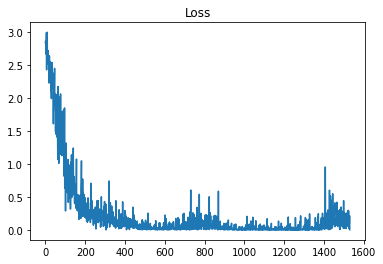

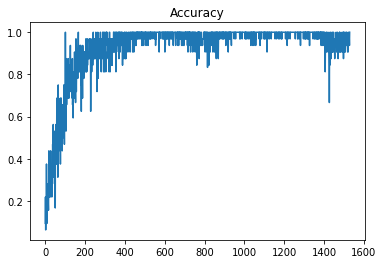

In [105]:
loss_hist = []
acc_hist = []

for _ in tqdm(range(30)):
    for x, c, y in dataloader:
        optimizer.zero_grad()

        x = x.to(device)
        c = c.to(device)
        y = y.to(device)

        x_dict = {'input_ids': x}
        c_dict = {'input_ids': c}
        logits = model(x_dict, c_dict)

        loss = F.cross_entropy(logits, y)

        _, preds = logits.max(-1)
        acc = torch.sum(preds == y).float() / x.shape[0]

        acc_hist.append(detorch(acc))
        loss_hist.append(detorch(loss))

        loss.backward()
        optimizer.step()


plt.figure()
plt.plot(loss_hist)
plt.title('Loss')

plt.figure()
plt.plot(acc_hist)
plt.title('Accuracy')